In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys
sys.path.append("../2_train_models")
from file_configs import MergedFilesConfig
from data_loading import extract_observed_profiles

from other_motif_utils import compute_per_position_ic, plot_motif_on_ax, trim_motifs_by_same_thresh

In [2]:
# specify what set of models to look at
cell_type = "K562"

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

# labels for each of the motifs stored in the modisco results file
motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

# what subset of the modisco results to look at (aligns with names)
patterns_to_keep = [0,1,2,3,4,5,6,7,8,9,13,15,19,21,23]

In [3]:
# Load the config object (filepath holder) for these models
config = MergedFilesConfig(cell_type, model_type, data_type)

proj_dir = config.proj_dir
figures_dir = proj_dir + "figures/"

genome_path = config.genome_path
chrom_sizes = config.chrom_sizes

# modisco results hdf5 object containing the motifs/patterns and subpatterns
modisco_results_path = config.modisco_profile_results_path

# what window length was used when contribution scores were input to modisco
# (needed to adjust seqlet coordinates)
slice_len = config.slice

In [4]:
# Load observed and predicted data across all PRO-cap peaks

true_profs = extract_observed_profiles(config.plus_bw_path,
                                       config.minus_bw_path,
                                       config.all_peak_path,
                                       out_window=out_window)

pred_profs = np.exp(np.load(config.pred_profiles_all_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Profile length: 1000
Num. Examples: 30534


In [32]:
# normalize the observed profiles to sum to 1,
# so that in later plots, individual peaks don't dominate

def normalize(profile, axis=-1):
    profile_sum = np.sum(profile, axis=axis, keepdims=True)
    
    # If any strand has no signal on it,
    # keep 0 as the quotient instead of dividing by 0
    profile_sum[profile_sum == 0] = 1  
    
    return profile / profile_sum


true_profs_norm = normalize(true_profs)

In [ ]:
def extract_profs_at_seqlets(seqlets, profiles,
                             out_window=out_window, target_prof_width=200):

    # note that this function won't work correctly if your out_window
    # doesn't match what your slice_len was set to when you ran modisco!
    # (seqlet coordinates will be off)
    
    assert len(profiles.shape) == 3 and profiles.shape[-1] == out_window, profiles.shape
    assert target_prof_width <= out_window // 2
    
    # extract coordinates for each seqlet
    peak_indexes = seqlets["example_idx"][:]
    seqlet_starts = seqlets["start"][:]
    seqlet_ends = seqlets["end"][:]
    seqlet_rcs = seqlets["is_revcomp"][:]
    
    # get coordinate centered on the seqlet center to extract the data profile around
    seqlet_mids = (seqlet_starts + seqlet_ends) // 2
    
    
    # For each seqlet, fetch the true/predicted profiles
    
    seqlet_profs = []
    for peak_index, seqlet_mid, is_seqlet_rc in zip(peak_indexes, seqlet_mids, seqlet_rcs):
        prof_start = seqlet_mid - target_prof_width
        prof_end = prof_start + target_prof_width * 2
        
        if prof_start < 0 or prof_end > out_window:
            # the seqlet is too close to the edge of the profile,
            # so we will pad with nans (ignored during averaging later)
        
            adjusted_prof_start = max(0, prof_start)
            adjusted_prof_end = min(out_window, prof_end)
            
            subset_of_prof = profiles[peak_index, :, adjusted_prof_start:adjusted_prof_end]
            
            num_bases_missing = target_prof_width * 2 - subset_of_prof.shape[-1]
            padded_array = np.full((subset_of_prof.shape[0], num_bases_missing), np.nan)
            
            if prof_start < 0:
                # the seqlet was too far left, so adjust the profile by shifting to the right
                prof_at_seqlet = np.concatenate((padded_array, subset_of_prof), axis=1)
            else:
                # the seqlet was too far right, so adjust the profile by shifting to the left
                prof_at_seqlet = np.concatenate((subset_of_prof, padded_array), axis=1)
                
        else:
            prof_at_seqlet = profiles[peak_index, :, prof_start:prof_end]
            
            if prof_at_seqlet.shape[-1] == 0:
                print(peak_index, prof_start, prof_end)
            
        
        if is_seqlet_rc:
            # we want to align profiles with respect to motif orientation.
            # so if the motif is flipped, flip the profile too (and swap strands)
            prof_at_seqlet = prof_at_seqlet[::-1, ::-1]
        
        seqlet_profs.append(prof_at_seqlet)  
    
    seqlet_profs = np.stack(seqlet_profs)
    
    assert seqlet_profs.shape[-1] == target_prof_width * 2, seqlet_profs.shape
    return seqlet_profs

In [97]:
def load_pattern_info_from_modisco_results(modisco_results_path, pattern_i):
    # parse the file structure of the modisco results hdf5 file to pull out
    # the pwm, cwm, and seqlet (seqlet = loci clustered into the motif) info;
    # then use the seqlet info to extract the observed/predicted PRO-cap profiles
    # at every seqlet.
    
    h5_file = h5py.File(modisco_results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
    assert pattern_group_name in h5_file.keys(), pattern_group_name
    
    new_patterns_grp = h5_file[pattern_group_name]
    assert len(new_patterns_grp.keys()) > 0, pattern_group_name
    
    pattern_grp = new_patterns_grp["pattern_" + str(patterns_to_keep[pattern_i])]

    pattern_pwm = pattern_grp["sequence"][:]
    pattern_cwm = pattern_grp["contrib_scores"][:]
    seqlets = pattern_grp["seqlets"]
    
    true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, true_profs_norm)
    pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, pred_profs)
    
    h5_file.close()
    
    return pattern_pwm, pattern_cwm, true_profs_at_seqlets, pred_profs_at_seqlets


def load_subpattern_info_from_modisco_results(modisco_results_path, pattern_i, subpattern_i):
    # same as the function load_pattern_info_from_modisco_results(), but for a subpattern
    
    h5_file = h5py.File(modisco_results_path, "r")
    
    pattern_group_name = "pos_patterns"
    assert pattern_group_name in ['pos_patterns', 'neg_patterns'], pattern_group_name
        
    assert pattern_group_name in h5_file.keys(), pattern_group_name
    
    new_patterns_grp = h5_file[pattern_group_name]
    assert len(new_patterns_grp.keys()) > 0, pattern_group_name
    
    pattern_grp = new_patterns_grp["pattern_" + str(patterns_to_keep[pattern_i])]
    
    subpattern_name = "subpattern_" + str(subpattern_i)
    assert subpattern_name in pattern_grp.keys(), subpattern_name

    subpattern = pattern_grp[subpattern_name]
    
    pattern_pwm = subpattern["sequence"][:]
    pattern_cwm = subpattern["contrib_scores"][:]
    seqlets = subpattern["seqlets"]
    
    true_profs_at_seqlets = extract_profs_at_seqlets(seqlets, true_profs_norm)
    pred_profs_at_seqlets = extract_profs_at_seqlets(seqlets, pred_profs)
    
    h5_file.close()
    
    return pattern_pwm, pattern_cwm, true_profs_at_seqlets, pred_profs_at_seqlets

In [217]:
def plot_avg_profile(profiles, ax, prof_width = 200, bottom_ticks=False,
                     color = None, tick_len=3, tick_fontsize=6):
    assert len(profiles.shape) == 3

    # Compute the mean profiles across all examples
    profs_mean = np.nanmean(profiles, axis=0)

    # Plot the average predictions
    prof_center = profs_mean.shape[-1] // 2
    ax.plot(profs_mean[0, prof_center - prof_width:prof_center + prof_width],
            color=color, linewidth=0.5)
    ax.plot(-profs_mean[1, prof_center - prof_width:prof_center + prof_width],
            color=color, alpha = 0.6, linewidth=0.5)

    # aesthetics -- set axes
    
    max_mean_val = np.max(profs_mean)
    
    if tick_len < 3:
        mean_ylim = max_mean_val * 1.1  # Make 5% higher
    else:
        mean_ylim = max_mean_val * 1.
        
    ax.set_ylim(-mean_ylim, mean_ylim)
    ax.set_xlim(0, 2 * prof_width)
    ax.label_outer()
    ax.set_yticks([])
    
    if not bottom_ticks:
        ax.set_xticks([])
        ax.spines[["left", "top", "right", "bottom"]].set_visible(False)
    else:
        ax.set_xticks([prof_width, 2 * prof_width], [0, prof_width],
                     fontsize=tick_fontsize)
        ax.tick_params("x", length=tick_len)
        
        ax.spines[["left", "top", "right"]].set_visible(False)
            
        if tick_len < 3:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 6, mean_ylim / 7,
                                     clip_on=False, zorder=50, color="white")
        else:
            rect = patches.Rectangle((0, -mean_ylim * 1.1), prof_width - 4, mean_ylim / 5,
                                     clip_on=False, zorder=50, color="white")
        ax.add_patch(rect)
            
        ax.spines['bottom'].set_position(('data', -mean_ylim))
        ax.spines["bottom"].set_color("#333333")
        


def plot_pattern_mult_subpatterns_and_profs(pattern_info, subpattern_infos,
                                      ylabel=None, save_path = None):
    
    # unpack all the info needed for the plot, and trim all motifs consistently
    
    pattern_pwm, pattern_cwm, true_profs_at_seqlets, pred_profs_at_seqlets = pattern_info
    
    pwm_subs, cwm_subs, true_profs_at_sub_seqlets, pred_profs_at_sub_seqlets = zip(*subpattern_infos)
    
    num_subpatterns = len(pwm_subs)
    
    # need to convert from PFM to actual PWM
    pattern_pwm = pattern_pwm * compute_per_position_ic(pattern_pwm)[:, None]
    pwm_subs = [pwm_sub * compute_per_position_ic(pwm_sub)[:, None] for pwm_sub in pwm_subs]
    
    trims = trim_motifs_by_same_thresh([pattern_pwm, pattern_cwm, *pwm_subs, *cwm_subs])
    
    # unpack output of trimming
    pwm_trim = trims[0]
    cwm_trim = trims[1]
    pwm_subs_trim = trims[2 : 2 + num_subpatterns]
    cwm_subs_trim = trims[2 + num_subpatterns : ]
    
    assert len(pwm_subs_trim) == len(cwm_subs_trim)
    assert len(pwm_subs_trim) == len(true_profs_at_sub_seqlets)
    
    
    fig, axes = plt.subplots(1 + num_subpatterns, 4,
                             figsize = (4.15, 0.45 + 0.475 * num_subpatterns),
                             gridspec_kw={'width_ratios': [1,1,1.3,1.3]},
                             dpi = 300)
    
    plot_colors = ["#001DAC", "#1B5AE3"]
    
    # plot sequence representation and average profiles for main pattern

    plot_motif_on_ax(pwm_trim, axes[0, 0])
    plot_motif_on_ax(cwm_trim, axes[0, 1])
    
    plot_avg_profile(true_profs_at_seqlets, axes[0, 2], color = plot_colors[0])
    plot_avg_profile(pred_profs_at_seqlets, axes[0, 3], color = plot_colors[1])

    # plot the same things for each subpattern
    
    for i in range(len(pwm_subs_trim)):
        plot_motif_on_ax(pwm_subs_trim[i], axes[i + 1, 0])
        plot_motif_on_ax(cwm_subs_trim[i], axes[i + 1, 1])
        
        for prof_i, prof in enumerate([true_profs_at_sub_seqlets, pred_profs_at_sub_seqlets]):
            plot_avg_profile(prof[i], axes[i + 1, 2 + prof_i],
                             color = plot_colors[i],
                             bottom_ticks = i == len(pwm_subs_trim) - 1,
                             tick_len = 2)
            
            axes[i + 1, 2 + prof_i].tick_params("x", labelsize=6)
    
    
    # aesthetics
    
    top_fontsize = 8
    axes[0,0].set_title("PWM", fontsize=top_fontsize, y=1.2)
    axes[0,1].set_title("CWM", fontsize=top_fontsize, y=1.2)
    axes[0,2].set_title("Avg. Observed\nProfile", fontsize=top_fontsize)
    axes[0,3].set_title("Avg. Predicted\nProfile", fontsize=top_fontsize)
    
    
    lpad = 16
    label_vertial_offset = -0.2
    side_fontsize = 6
    
    axes[0, 0].set_ylabel("Main\nPattern",
                          fontsize=side_fontsize, rotation=0, labelpad=lpad,
                          y = 0.25)
    if len(pwm_subs_trim) == 1:
        axes[1, 0].set_ylabel("Inr-Like\nSub-Pattern",
                              fontsize=side_fontsize, rotation=0, labelpad=lpad,
                              y = 0.25)
    else:
        for i in range(len(pwm_subs_trim)):
            axes[i + 1, 0].set_ylabel("Inr-Like\nSub-Pattern\n" + str(i+1),
                                      fontsize=side_fontsize, rotation=0, labelpad=lpad,
                                      y = 0.05)
                
    # add motif name in the upper left
    
    twinax = axes[0,0].twinx()
    twinax.yaxis.set_label_position('left')
    twinax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    twinax.set_yticks([])
    twinax.set_ylabel(ylabel, weight="bold", rotation=0, y=1.35, labelpad=19.5,
                      horizontalalignment="center")
    
        
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0., dpi = 300)
    
    plt.show()

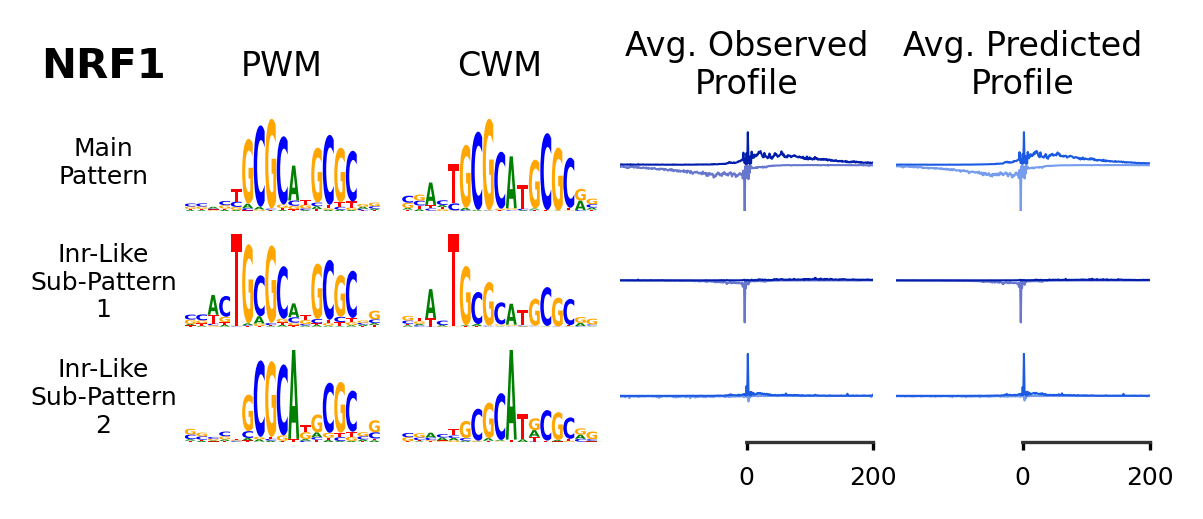

In [218]:
def plot_multi_subclusters(modisco_results_path, pattern_i, subpattern_is, motif_names, save_dir = None):
    # arguments:
    #  - pattern_i: the index of the overall modisco hit/result/pattern/motif to plot
    #  - subpattern_is: list of the indexes of the subpatterns/submotifs to plot
    #      (you can figure out what subpatterns you want by just plotting all of them initially)
    
    pattern_info = load_pattern_info_from_modisco_results(modisco_results_path, pattern_i)

    subpattern_infos = []
    for subpattern_i in subpattern_is:
        subpattern_infos.append(load_subpattern_info_from_modisco_results(modisco_results_path,
                                                                          pattern_i, subpattern_i))


    if save_dir is not None:
        save_path = save_dir + "3_subclusters_" + motif_names[pattern_i].replace("/", "-") + ".png" 
    else:
        save_path = None
    
    plot_pattern_mult_subpatterns_and_profs(pattern_info, subpattern_infos,
                                            motif_names[pattern_i], save_path = save_path)


plot_multi_subclusters(modisco_results_path, 4, [3, 7], motif_names, save_dir = figures_dir)

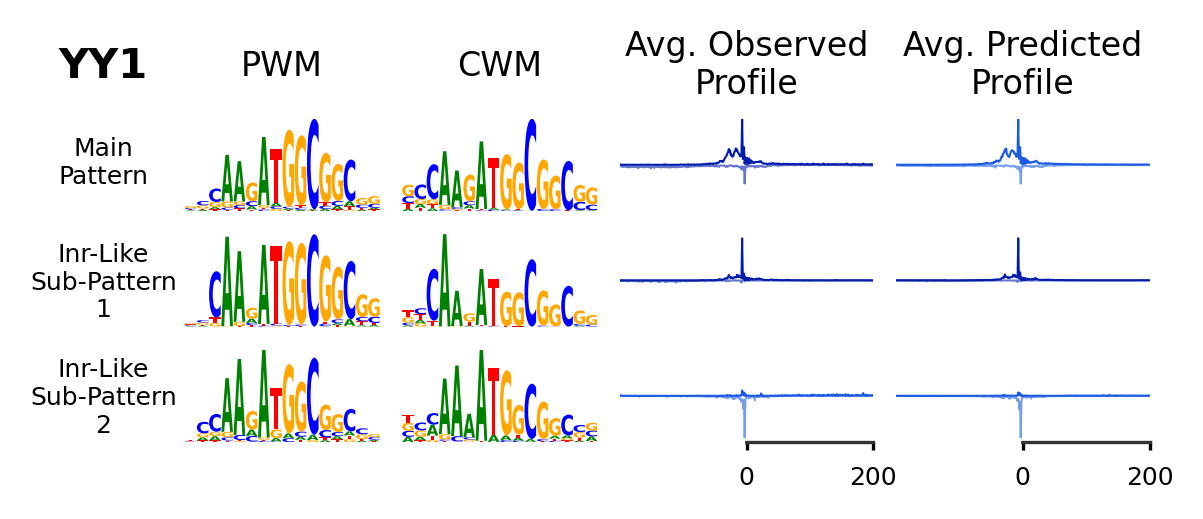

In [219]:
plot_multi_subclusters(modisco_results_path, 8, [1, 6], save_dir = figures_dir)

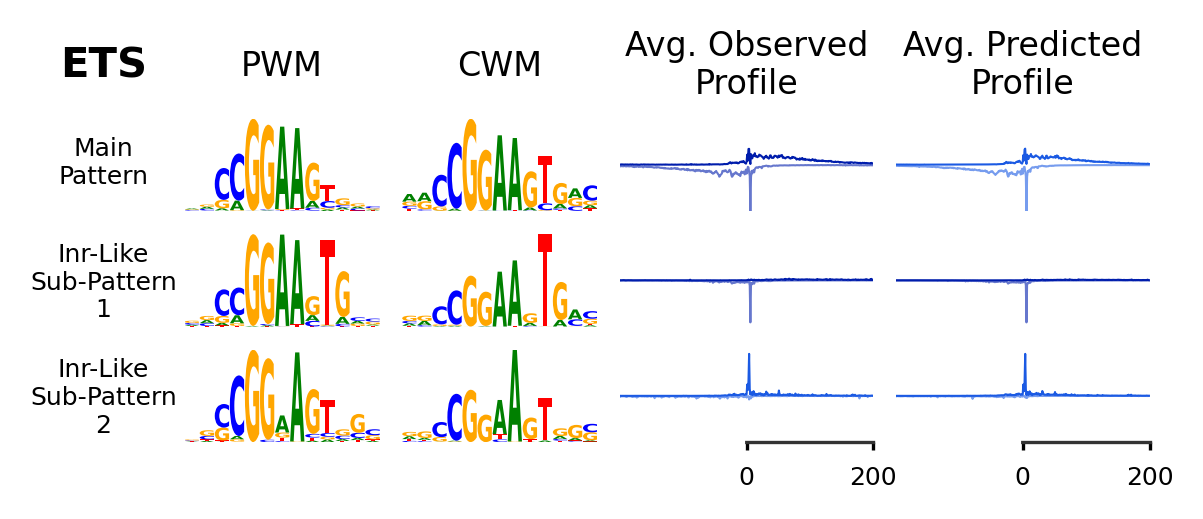

In [220]:
plot_multi_subclusters(modisco_results_path, 2, [4, 9], save_dir = figures_dir)

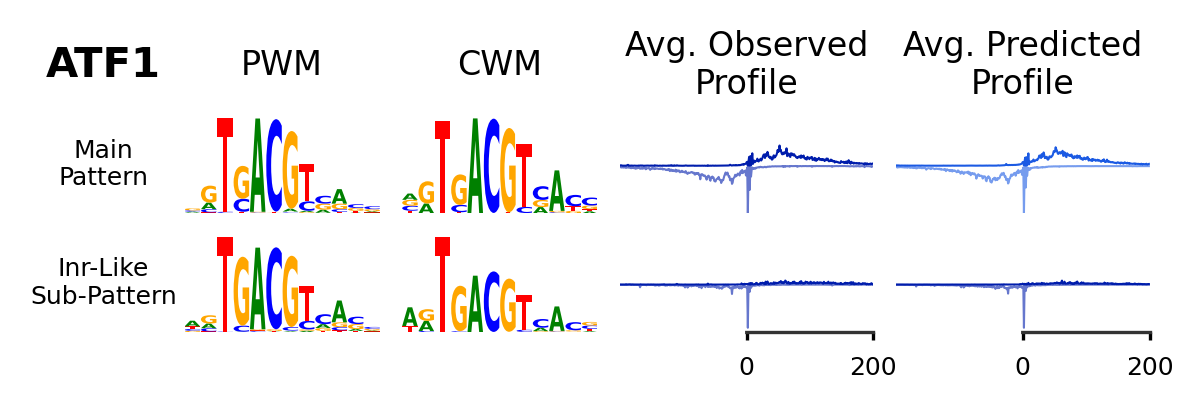

In [221]:
plot_multi_subclusters(modisco_results_path, 5, [4], save_dir = figures_dir)

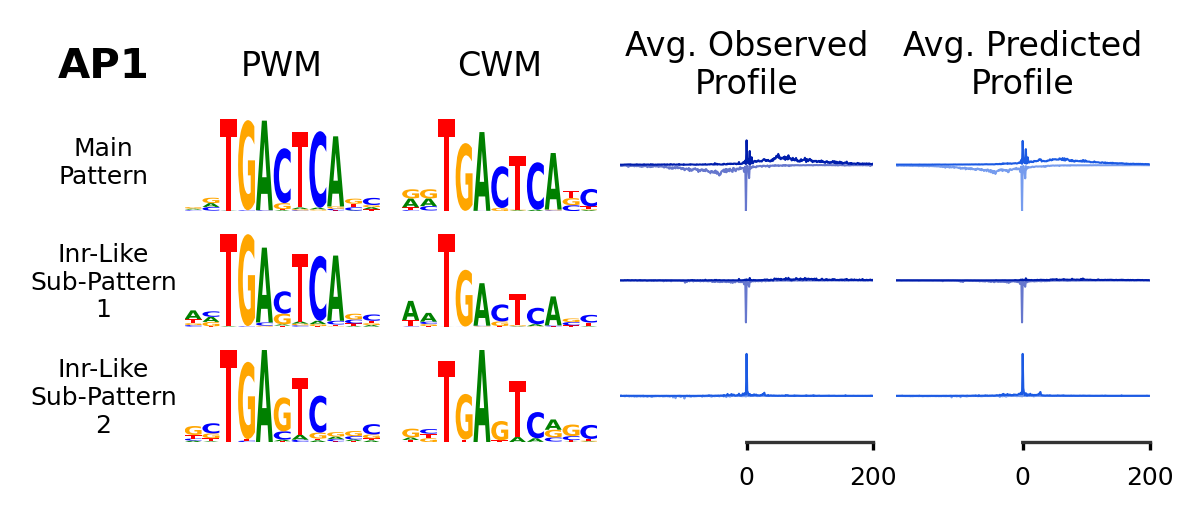

In [222]:
plot_multi_subclusters(modisco_results_path, 9, [2, 6], save_dir = figures_dir)